In [1]:
import shap
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql.dataframe import DataFrame
from typing import Callable, List, Dict
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
import numpy as np

In [2]:
import pandas as pd

In [3]:
import sys
sys.path.append('..')
from src.data import transform_dataset

In [4]:
spark = SparkSession.builder.appName('model-intepret').getOrCreate()

22/05/17 23:53:12 WARN Utils: Your hostname, nbb-173-74a resolves to a loopback address: 127.0.1.1; using 192.168.1.32 instead (on interface wlp0s20f3)
22/05/17 23:53:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


22/05/17 23:53:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [15]:
spark.sparkContext.setLogLevel('ERROR')

In [16]:
test_data = spark.read.csv('../data/processed/test.csv/', header=True)
train_data = spark.read.csv('../data/processed/train.csv/', header=True)

In [17]:
test_data = transform_dataset(test_data)
train_data = transform_dataset(train_data)

In [18]:
rf = PipelineModel.load('../models/rf/') #random forrest
lr = PipelineModel.load('../models/lr/') # logistic regression
gbdt = PipelineModel.load('../models/gbdt/') # grad boosting decision tree
svm = PipelineModel.load('../models/svm/') # svm

In [19]:
def evaluate_models(
    models: Dict[str, PipelineModel],
    test_data: DataFrame,
):
    res = {
        'roc_auc': {},
        'f1': {},
        'accuracy': {},
        'recall': {},
        'precision': {},
    }
    MulticlassClassificationEvaluator()
    for model_name, model in models.items():
        predicted = model.transform(test_data)
        res['roc_auc'][model_name] = BinaryClassificationEvaluator(labelCol='Churn', metricName='areaUnderROC').evaluate(predicted)
        res['f1'][model_name] = MulticlassClassificationEvaluator(labelCol='Churn', metricName='f1').evaluate(predicted)
        res['accuracy'][model_name] = MulticlassClassificationEvaluator(labelCol='Churn', metricName='accuracy').evaluate(predicted)
        res['recall'][model_name] = MulticlassClassificationEvaluator(labelCol='Churn', metricName='weightedRecall').evaluate(predicted)
        res['precision'][model_name] = MulticlassClassificationEvaluator(labelCol='Churn', metricName='weightedPrecision').evaluate(predicted)
    return res

In [20]:
eval_results = evaluate_models(
    {'RF': rf, 'LR': lr, 'GBDT': gbdt, 'SVM': svm },
    test_data
)

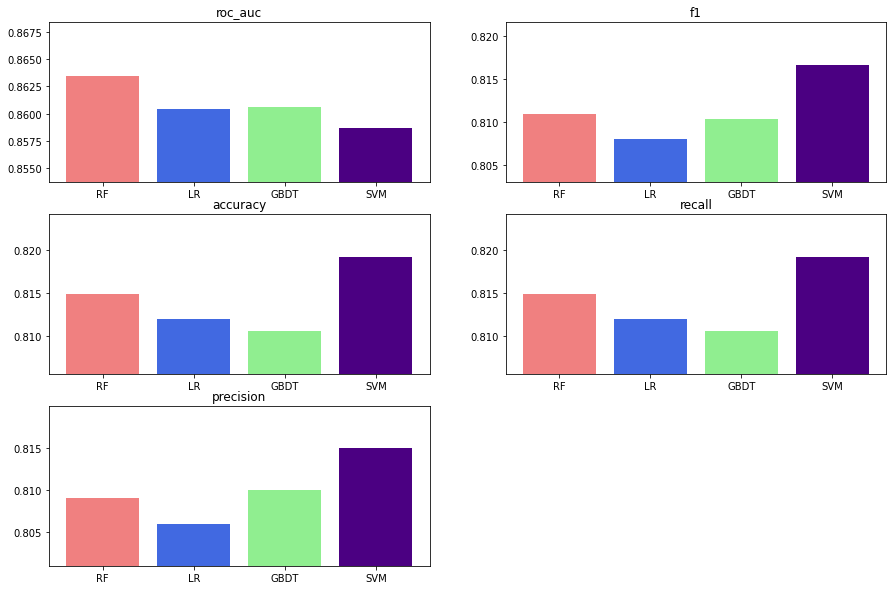

In [21]:
for i, metric_name in enumerate(eval_results.keys()):
    values = eval_results[metric_name]
    ax = plt.subplot(len(eval_results) // 2 + 1, 2, i + 1)
    ax.bar(x = list(values.keys()), height = list(values.values()),
           color = ['lightcoral', 'royalblue', 'lightgreen', 'indigo'])
    ax.set_ylim(bottom=min(values.values()) - 0.005, top=max(values.values()) + 0.005)
    ax.title.set_text(metric_name)

In [22]:
class ModelWrapper:
    # do not work with svm
    def __init__(self, model: PipelineModel):
        self.model = model
    
    def predict(self, X: pd.DataFrame):
        sparkdata = spark.createDataFrame(X)
        return np.array(self.model.transform(sparkdata).select('prediction').
                        toPandas().values.flatten().tolist())
    
    def predict_proba(self, X: pd.DataFrame):
        sparkdata = spark.createDataFrame(X)
        prediction = self.model.transform(sparkdata).select('probability').toPandas().values.flatten().tolist()
        proba_list = [vector.values.tolist() for vector in prediction]
        return np.array(proba_list)
    
    def __call__(self, X: pd.DataFrame):
        return self.predict_proba(X)[:, 1]

In [80]:
def explain_model(wrapped_model: ModelWrapper, data: DataFrame, n_samples=None):
    X = data.toPandas()
    if n_samples is not None:
        X = X[:n_samples]
    med = X.median().values.reshape((1, X.shape[1]))
    explainer = shap.Explainer(wrapped_model, X)
    shap_values = explainer(X)
    shap.plots.bar(shap_values, max_display=10)
    shap.summary_plot(shap_values, X)

In [81]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [82]:
class SVMWrapper(ModelWrapper):
    def __init__(self, model: PipelineModel):
        super().__init__(model)
    
    def predict_proba(self, X: pd.DataFrame):
        sparkdata = spark.createDataFrame(X)
        prediction = self.model.transform(sparkdata).select('rawPrediction').toPandas().values.flatten().tolist()
        proba_list = [vector.values.tolist() for vector in prediction]
        return sigmoid(np.array(proba_list))
    

### Random Forrest

Permutation explainer: 101it [09:22,  5.74s/it]                                 


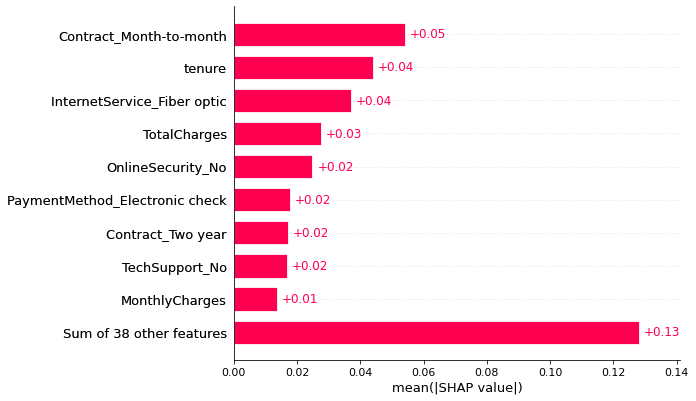

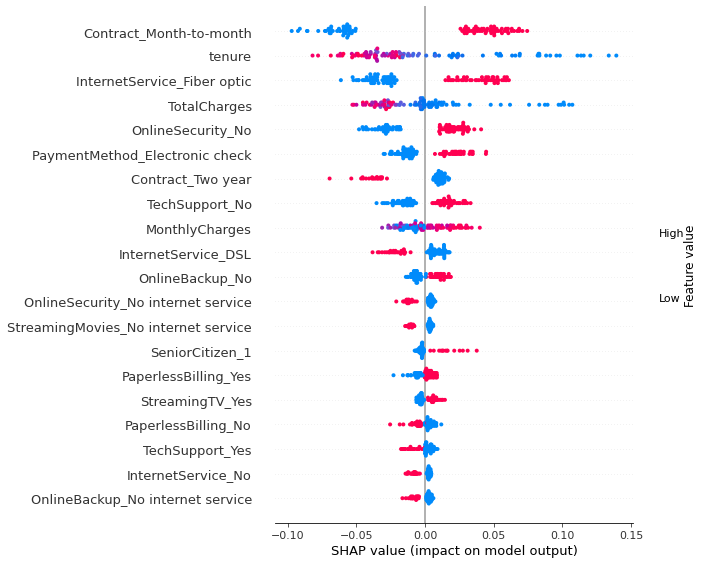

In [83]:
explain_model(ModelWrapper(rf), test_data, 100)

### SVM

Permutation explainer: 101it [06:27,  3.96s/it]                                 


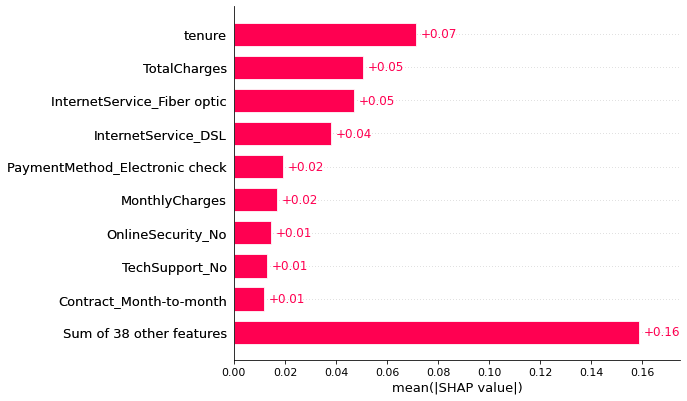

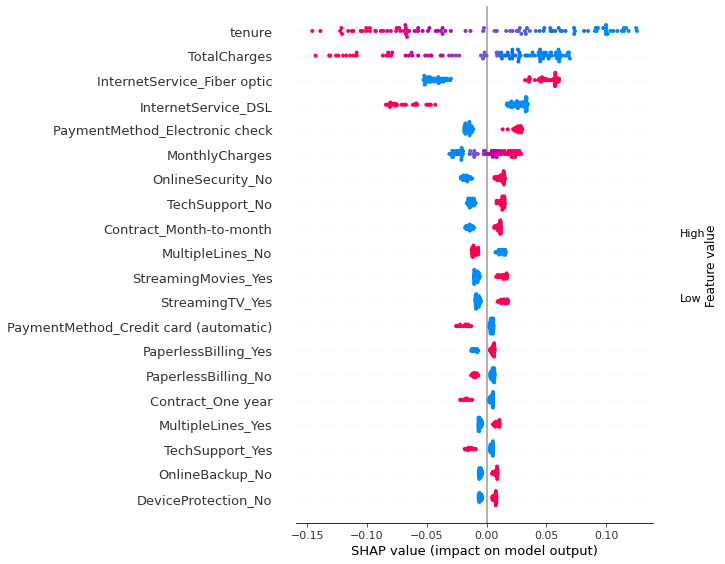

In [84]:
explain_model(SVMWrapper(svm), test_data, 100)

### GBDT

Permutation explainer: 101it [06:27,  3.96s/it]                                 


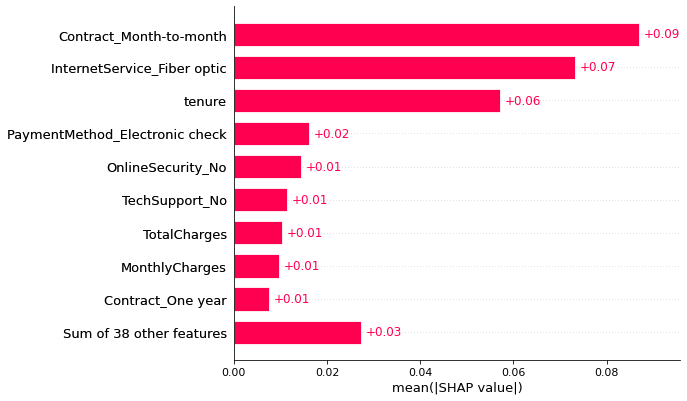

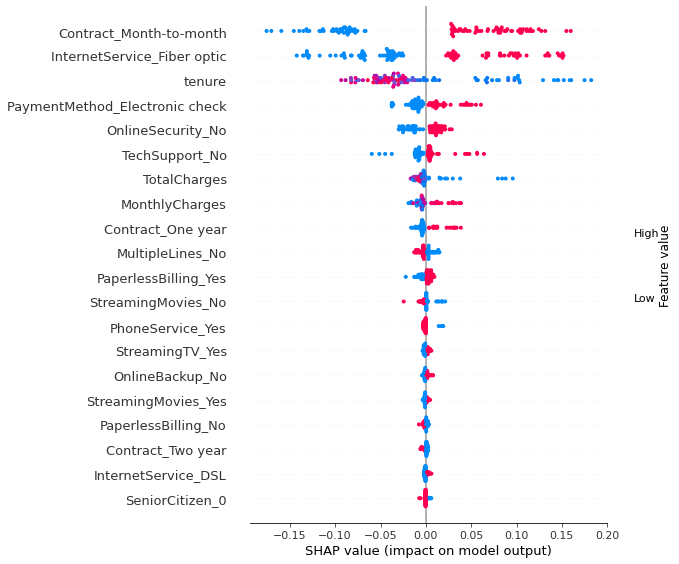

In [85]:
explain_model(ModelWrapper(gbdt), test_data, 100)

### Logistic Regression

Permutation explainer: 101it [06:27,  3.96s/it]                                 


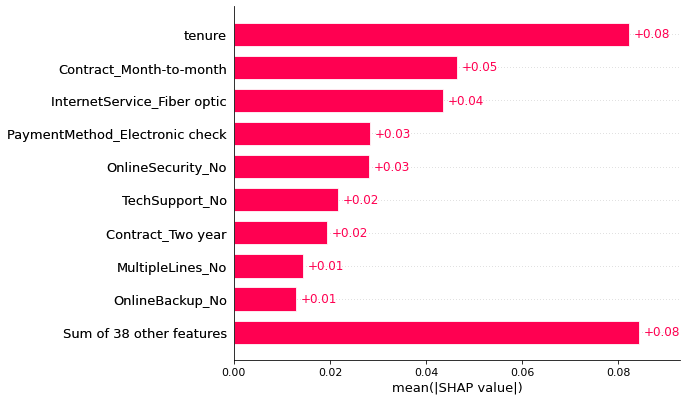

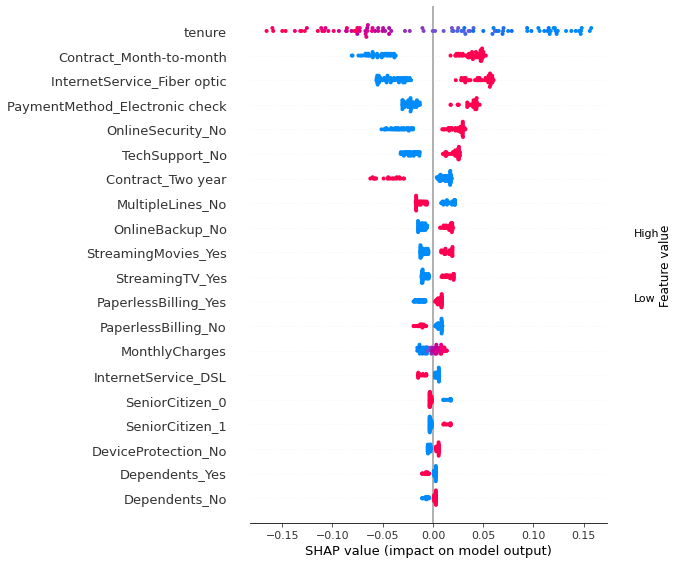

In [86]:
explain_model(ModelWrapper(lr), test_data, 100)